# RNN을 이용한 SMS Spam 분류
- 캐글에서 제공하는 스팸메일 데이터

### 런타임에서 다시 시작

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumGothic')

### 파일 업로드

In [4]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving spam.csv to spam (1).csv


In [5]:
df = pd.read_csv(filename, encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 데이터 전처리

In [6]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
df['v1'] = df['v1'].replace(['ham','spam'],[0,1]) # 레이블(Labl Encoding) 인코더를 사용해서 동일한 기능 가능
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [8]:
# Null 검사
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [9]:
# 데이터 중복이 있는지 확인
df['v2'].nunique()

5169

In [10]:
# 데이터 중복 제거
df = df.drop_duplicates('v2', keep='first')

In [11]:
df['v1'].value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [12]:
X_data = df['v2'].values
y_data = df['v1'].values
print('SMS 본문의 개수:', len(X_data))
print('레이블의 개수:', len(y_data))

SMS 본문의 개수: 5169
레이블의 개수: 5169


In [13]:
# 단어 집합(vocabulary)을 만들고 크기를 확인
t = Tokenizer()
t.fit_on_texts(X_data)
sequences = t.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 8921


### 전체 데이터셋의 길이를 임의의 숫자(100)에 맞춤

In [14]:
X_data = sequences

In [15]:
data = pad_sequences(X_data, maxlen=100)
data.shape

(5169, 100)

In [16]:
# 훈련&테스트 데이터 만들기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, y_data, stratify=y_data, test_size=0.2, random_state=seed
)

In [17]:
X_train.shape, X_test.shape

((4135, 100), (1034, 100))

### 모델 정의/ 설정/학습

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

In [19]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32))             # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          285472    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 6s 81ms/step - loss: 0.4403 - accuracy: 0.8517 - val_loss: 0.2390 - val_accuracy: 0.9033
Epoch 2/10
56/56 [==============================] - 4s 75ms/step - loss: 0.1242 - accuracy: 0.9710 - val_loss: 0.0742 - val_accuracy: 0.9831
Epoch 3/10
56/56 [==============================] - 4s 77ms/step - loss: 0.0774 - accuracy: 0.9787 - val_loss: 0.0533 - val_accuracy: 0.9891
Epoch 4/10
56/56 [==============================] - 5s 85ms/step - loss: 0.0371 - accuracy: 0.9896 - val_loss: 0.0757 - val_accuracy: 0.9794
Epoch 5/10
56/56 [==============================] - 4s 80ms/step - loss: 0.0276 - accuracy: 0.9940 - val_loss: 0.0647 - val_accuracy: 0.9807
Epoch 6/10
56/56 [==============================] - 4s 79ms/step - loss: 0.0290 - accuracy: 0.9904 - val_loss: 0.0713 - val_accuracy: 0.9782
Epoch 7/10
56/56 [==============================] - 4s 78ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.0716 - val_accuracy: 0.9782
Epoch 8/10
56

In [22]:
acc = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

33/33 - 0s - loss: 0.0599 - accuracy: 0.9816
Accuracy: 0.9816


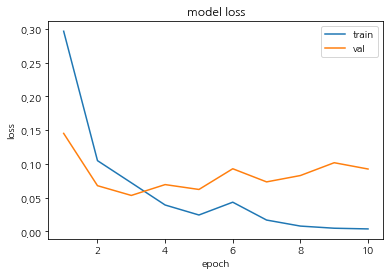

In [36]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()